In [1]:
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import L_BFGS_B, SPSA
from qiskit.primitives import Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import QuantumCircuit
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit_nature.second_q.mappers import ParityMapper

In [2]:
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.725",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

In [3]:
mapper = ParityMapper(num_particles=es_problem.num_particles)

In [4]:
print("Hamiltonian of Molecule:")
hamiltonian = es_problem.hamiltonian.second_q_op()
qubit_op = mapper.map(hamiltonian)
aux_op = mapper.map(es_problem.second_q_ops()[1])
for pauli, coeff in sorted(qubit_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

Hamiltonian of Molecule:
-1.05016043 * II
+0.40421466 * IZ
+0.18037525 * XX
-0.40421466 * ZI
-0.01134688 * ZZ


In [5]:
class ThermalNoiseModel(NoiseModel):
    def __init__(self, t1, t2):
        super().__init__()
        self.t1 = t1
        self.t2 = t2
        self.time_cx = 150
        self.time_swap = 40
        self.single_gate_times = {
            "h": 40,
            "x": 40,
            "y": 40,
            "measure": 100
        }

        self.add_errors()

    def add_errors(self):
        for gate, time in self.single_gate_times.items():
            self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, time), gate)
        self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, self.time_cx).expand(thermal_relaxation_error(self.t1, self.t2, self.time_cx)), "cx")
        self.add_all_qubit_quantum_error(thermal_relaxation_error(self.t1, self.t2, self.time_swap).expand(thermal_relaxation_error(self.t1, self.t2, self.time_swap)), "swap")

In [6]:
seed = 100

noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": [(0, 1), (1, 2)],
        "noise_model": ThermalNoiseModel(10e3, 5e3),
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed}
)

In [7]:
ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

vqe = VQE(noiseless_estimator, ansatz, SPSA())
vqe.initial_point = [0.0] * ansatz.num_parameters

In [8]:
for gate, cnt in ansatz.decompose(reps=3).count_ops().items():
    print(f"{gate.upper()} Gate - {cnt}")

H Gate - 8
CX Gate - 4
R Gate - 2
SDG Gate - 2
RZ Gate - 2
S Gate - 2
U Gate - 1


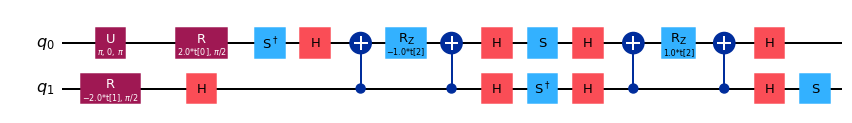

In [9]:
ansatz.decompose(reps=3).draw(output="mpl")

In [8]:
result = vqe.compute_minimum_eigenvalue(qubit_op, aux_op)
res = es_problem.interpret(result)
res.total_energies[0]

-1.128969946445569

In [13]:
result.extracted_transformer_energies.pop(
            "nuclear_repulsion_energy", None
        )

AttributeError: 'VQEResult' object has no attribute 'extracted_transformer_energies'

In [9]:
res.groundenergy

-1.8588695477145345

In [11]:
calculated = res.eigenvalues[0] + res._nuclear_repulsion_energy
actual = res._hartree_fock_energy
print("Total Calculated Energy:", calculated)
print("Actual Energy:", res._hartree_fock_energy)
print(f"Percentage Error: {(calculated - actual) / calculated * 100:.2f}%")

Total Calculated Energy: -1.006476385361355
Actual Energy: -1.117343269122583
Percentage Error: -11.02%


In [12]:
distances = np.hstack((np.arange(0.2, 1.55, 0.05), np.arange(1.75, 4.25, 0.25)))
vqe_energies = []

for distance in tqdm(distances, desc="Calculating energies"):
    driver = PySCFDriver(
        atom=f"H 0 0 0; H 0 0 {distance}",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    es_problem = driver.run()
    qubit_op, aux_op = es_problem.second_q_ops()
    qubit_op, aux_op = mapper.map(qubit_op), mapper.map(aux_op)
    raw_result = vqe.compute_minimum_eigenvalue(qubit_op, aux_op)
    res = es_problem.interpret(raw_result)
    vqe_energies.append(res.total_energies[0])

Calculating energies: 100%|██████████| 37/37 [00:22<00:00,  1.63it/s]


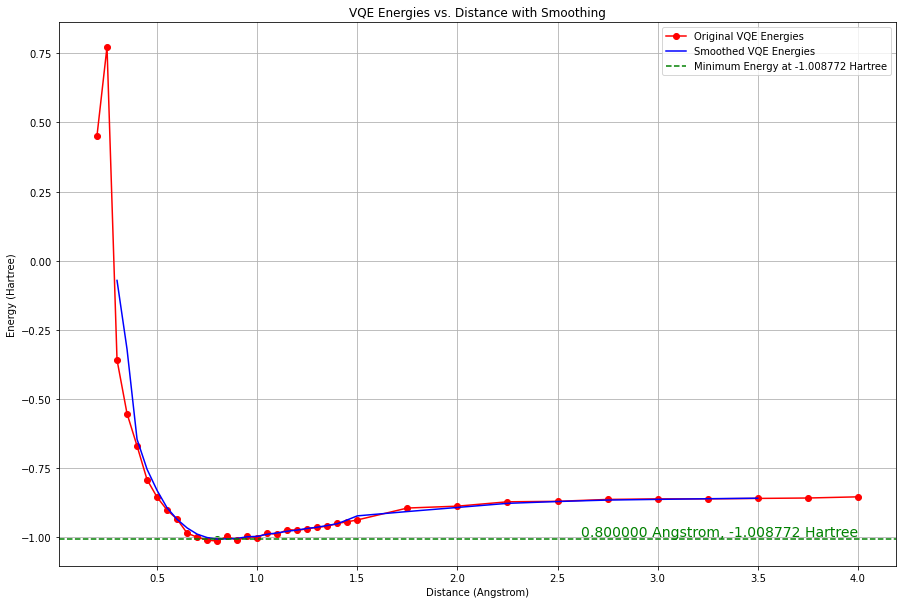

The minimum energy is -1.008772 Hartree at a distance of 0.800000 Angstrom


In [13]:
kernel_size = 5
kernel = np.ones(kernel_size) / kernel_size

# Apply convolution to smooth the energies
smoothed_energies = np.convolve(vqe_energies, kernel, mode='valid')

# Adjust distances to match the length of the smoothed energies
adjusted_distances = distances[(kernel_size-1)//2:-(kernel_size-1)//2] if kernel_size % 2 != 0 else distances[(kernel_size)//2:-(kernel_size)//2]

# Find the minimum energy and corresponding distance
min_energy = smoothed_energies.min()
min_energy_distance = adjusted_distances[smoothed_energies.argmin()]

# Plot the original and smoothed energies
plt.figure(figsize=(15, 10))
plt.plot(distances, vqe_energies, 'o-', label='Original VQE Energies', color='red')
plt.plot(adjusted_distances, smoothed_energies, '-', label='Smoothed VQE Energies', color='blue')

# Draw a horizontal line at the minimum energy point
plt.axhline(min_energy, color='green', linestyle='--', label=f'Minimum Energy at {min_energy:.6f} Hartree')
plt.scatter(min_energy_distance, min_energy, color='green')  # Mark the minimum point
plt.text(distances[-1], min_energy, f'{min_energy_distance:.6f} Angstrom, {min_energy:.6f} Hartree', color='green', fontsize=14, ha='right', va='bottom')


plt.xlabel('Distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('VQE Energies vs. Distance with Smoothing')
plt.legend()
plt.grid(True)
plt.show()

print(f"The minimum energy is {min_energy:.6f} Hartree at a distance of {min_energy_distance:.6f} Angstrom")